## Déploiement et inférence avec MLflow

Dans ce chapitre, vous découvrirez une infrastructure de déploiement de bout en bout pour notre système d'apprentissage automatique (ML), y compris le composant d'inférence avec l'utilisation de MLflow. Nous passerons ensuite au déploiement de notre modèle dans un système de ML natif du cloud (AWS SageMaker) et dans un environnement hybride avec Kubernetes. 

L'objectif principal de l'exposition à ces différents environnements est de vous doter des compétences nécessaires pour déployer un modèle de ML sous les différentes contraintes environnementales (cloud natif et sur site) de différents projets. 

ce chapitre consiste à déployer le modèle PsyStock pour prédire le prix du Bitcoin (BTC/USD) sur la base des 14 derniers jours de comportement du marché sur lesquels vous avez travaillé jusqu'à présent tout au long du livre. Nous allons le déployer dans plusieurs environnements à l'aide d'un flux de travail. En particulier, nous examinerons les sections suivantes dans ce chapitre :

* Démarrage d'un registre de modèles local

* Configuration d'un travail d'inférence par lots

* Création d'un processus d'API pour l'inférence

* Déploiement de vos modèles pour le scoring par lots dans Kubernetes

* Réalisation d'un déploiement cloud avec AWS SageMaker

## Démarrage d'un registre de modèles local 

Avant d'exécuter les sections suivantes de ce chapitre, vous devez configurer un registre de modèles et un serveur de suivi centralisés. Nous n'avons pas besoin de l'intégralité du Data Science Workbench, nous pouvons donc passer directement à une variante plus légère du workbench intégré au modèle que nous allons déployer dans les sections suivantes. Vous devriez être dans le dossier racine du code de ce chapitre, disponible sur https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/tree/master/Chapter09

Ensuite, accédez au répertoire gradflow et démarrez une version allégée de l'environnement pour servir votre modèle, comme suit :


    $ cd gradflow
    $ export MLFLOW_TRACKING_URI=http://localhost:5000 
    $ make gradflow-light


Après avoir configuré notre infrastructure pour le déploiement d'API avec MLflow avec le modèle récupéré du registre ML, nous passerons ensuite aux cas où nous devons évaluer certaines données d'entrée par lots. Nous allons préparer un travail d'inférence par lots avec MLflow pour le problème de prédiction à résoudre.

## La configuration d'un travail d'inférence par lots, 

le code requis pour cette section se trouve dans le dossier pystock-inference-api. L'infrastructure MLflow est fournie dans l'image Docker accompagnant le code, comme illustré dans la figure suivante :

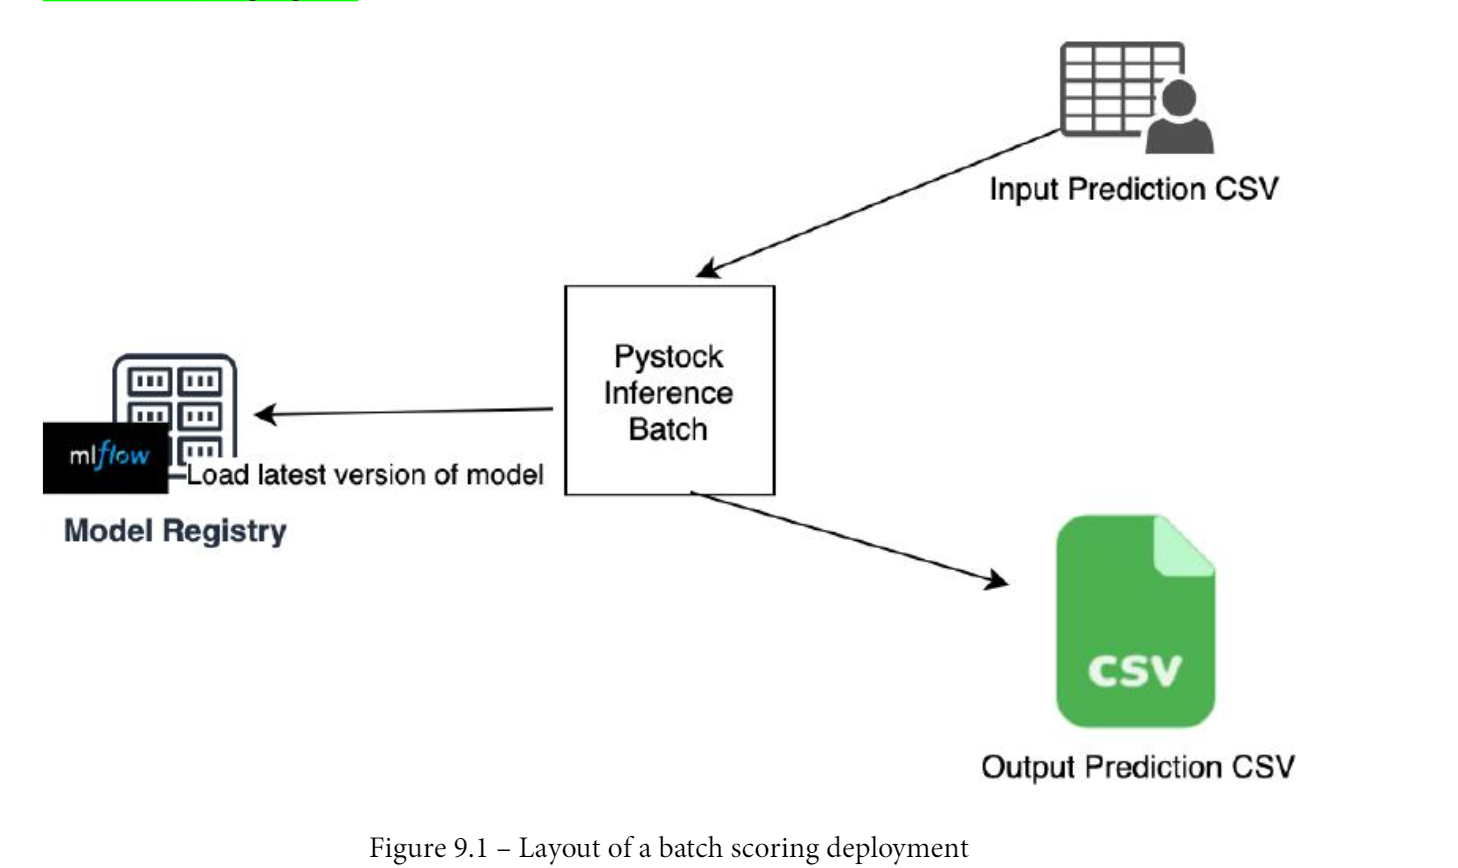

Si vous avez un accès direct aux artefacts, vous pouvez procéder comme suit. Le code est disponible dans le répertoire pystock-inference-batch. Afin de configurer un travail d'inférence par lots, nous allons suivre ces étapes : 

1. Importez les dépendances de votre travail par lots ; parmi les dépendances pertinentes, nous incluons pandas, mlflow et xgboost :

In [ ]:
import pandas as pd
import mlflow
import mlflow.pyfunc

2. Nous allons ensuite charger start_run en appelant mlflow.start_run et charger les données à partir du fichier d'entrée de notation input.csv :

In [ ]:
if __name__ == "__main__":

    with mlflow.start_run(run_name="batch_scoring") as run:

        data=pd.read_csv("data/input.csv",header=None)


3. Ensuite, nous chargeons le modèle à partir du registre en spécifiant la valeur model_uri, en fonction des détails du modèle :

In [ ]:
        model_name = "training-model-psystock"
        stage = 'Production'

        model = mlflow.pyfunc.load_model(
                model_uri=f"models:/{model_name}/{stage}"
        )

4. Nous sommes maintenant prêts à prédire sur l'ensemble de données que nous venons de lire en exécutant model.predict :

In [ ]:
        y_probas=model.predict(data)

       
        
       

5. Enregistrez les prédictions par lots. Cela consiste essentiellement à mapper la cible de probabilité (de la hausse du marché) dans la variable y_preds à une valeur allant de 0 à 1 :

In [ ]:
         y_preds = [1 if  y_proba > 0.5 else 0 for y_proba in y_probas]
        
        data[len(data.columns)] =y_preds
        
        result = data

        result.to_csv("data/output.csv")

6. Nous devons maintenant packager le travail en tant qu'image Docker afin de pouvoir l'exécuter facilement en production :



    FROM continuumio/miniconda3

    WORKDIR /batch-scoring/

    RUN pip install mlflow==1.16.0

    RUN pip install pandas==1.2.4

    COPY batch_scoring.py   /batch-scoring/
    COPY MLproject          /batch-scoring/

    ENV MLFLOW_TRACKING_URI=http://localhost:5000

    ENTRYPOINT ["mlflow run . --no-conda"]



7. Créez votre image Docker et balisez-la pour pouvoir la référencer :


    docker build . -t pystock-inference-batch


8. Exécutez votre image Docker en exécutant la commande suivante :


    docker run -i pystock-inference-batch

Une image Docker dans ce cas vous fournit un mécanisme pour exécuter votre tâche de notation par lots dans n'importe quel environnement informatique qui prend en charge les images Docker dans le cloud ou sur site. Nous allons maintenant illustrer la génération d'un environnement d'inférence d'API dockerisé pour MLflow.

## Création d'un processus API pour l'inférence 

Le code requis pour cette section se trouve dans le dossier pystock-inference-api. L'infrastructure MLflow est fournie dans l'image Docker accompagnant le code, comme illustré dans la figure suivante :


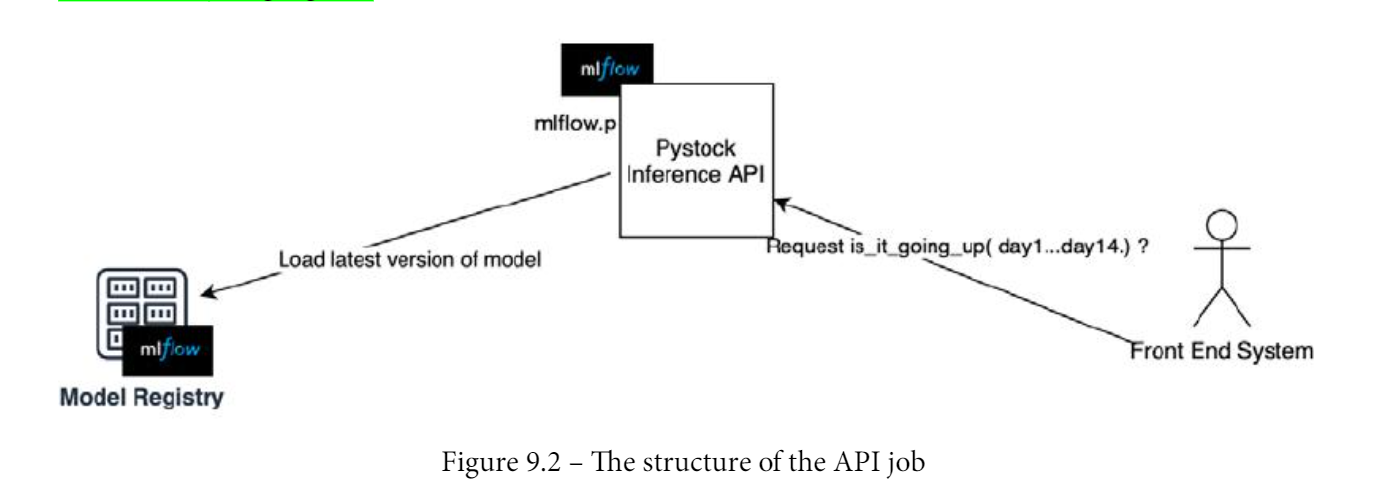

La configuration d'un système d'API est assez simple en s'appuyant sur l'environnement API REST intégré de MLflow. Nous nous appuierons sur le magasin d'artefacts sur le système de fichiers local pour tester les API. Avec l'ensemble de commandes suivant, qui consiste essentiellement à utiliser la commande models serve dans la CLI, nous pouvons servir nos modèles :



      cd /gradflow/
      
      export MLFLOW_TRACKING_URI=http://localhost:5000
      mlflow models serve -m "models:/training-model-psystock/Production" -p 6000


Nous allons ensuite empaqueter les commandes précédentes dans une image Docker afin qu'elle puisse être utilisée sur n'importe quel environnement pour le déploiement. Les étapes pour y parvenir sont les suivantes :

1. Générez une image Docker spécifiant le répertoire de travail et les commandes à lancer comme point d'entrée :




    FROM continuumio/miniconda3

    WORKDIR /batch-scoring/

    RUN pip install mlflow==1.16.0

    RUN pip install pandas==1.2.4

    COPY batch_scoring.py   /batch-scoring/
    COPY MLproject          /batch-scoring/

    ENV MLFLOW_TRACKING_URI=http://localhost:5000

    ENTRYPOINT ["mlflow models serve -m "models:/training-model-psystock/Production" -p 6000"]


2. Créez votre image Docker :



    docker build . -t pystock-inference-api


3. Exécutez votre image Docker :


    docker run -i pystock-inference-api -p 6000:6000


À ce stade, vous avez dockerisé l'infrastructure de l'API et pouvez la déployer sur un environnement de calcul qui vous convient. Après avoir exploré l'interaction de MLow et un déploiement cloud natif sur la plate-forme AWS, nous allons maintenant examiner un déploiement indépendant de tout fournisseur